In [1]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

import ffn


from backtester import backtest as bt

%matplotlib inline

In [2]:
def create_pairs(tickers):
        result = []
        for p1 in range(len(tickers)):
                for p2 in range(p1+1,len(tickers)):
                        result.append([tickers[p1],tickers[p2]])
        return result
    
    
def find_ssd(df, pairs):
    ssd = {}
    for p in pairs:
        pair = p[0]+','+p[1]
        A = df[p[0]]
        B = df[p[1]]
        s = np.sum((A-B)**2)
        if s == 0.0:
            s = 999.9
        ssd[pair] = s
        
    return ssd


def find_tradeble_pairs(ssd):
    sorted_lst = sorted(ssd, key=ssd.get)
    fpair = sorted_lst[0].split(",")
    spair = sorted_lst[1].split(",")
    tpair = sorted_lst[2].split(",")
    
    return [fpair, spair, tpair]


def find_entry_exit(spread):
    mean = np.mean(spread)
    stdev = np.std(spread)
    upper = mean+2*stdev
    lower = mean-2*stdev
    
    return mean, upper, lower

def create_signal(df, pair, m, u, l):
    spread = df[pair[0]] - df[pair[1]]
    previous_spread = spread.shift(1)
    bt_df = pd.DataFrame()
    
    bt_df[pair[0]] = df[pair[0]]
    bt_df[pair[1]] = df[pair[1]]
    bt_df['shortsignal'] = ((spread < u) & (previous_spread > u))
    bt_df['longsignal'] = ((spread > l) & (previous_spread < l))
    bt_df['closelong'] = np.where(spread > m, 1, 0)
    bt_df['closeshort'] = np.where(spread < m, 1, 0)
    
    return bt_df


def trading(df_formation, df_trading):
    returns = pd.DataFrame()
    
    ssd = find_ssd(df_formation, pairs)
    selected = find_tradeble_pairs(ssd)
    
    for pair in selected:
        bt_name = pair[0]+pair[1]
        
        spread = df_formation[pair[0]] - df_formation[pair[1]]
        m, u, l = find_entry_exit(spread) 
        
        bt_df = create_signal(df_trading, pair, m, u, l)
        ret = bt(bt_df, pair[0], pair[1])
        
        returns[bt_name] = ret.returns
        print(pair)
        
    returns['mean'] = returns.mean(axis=1)
    returns = returns.set_index(df_trading.index)
    return returns['mean']
    
    

def backtest(df):
    overall_ret = pd.DataFrame()
    
    start = pd.Timestamp('2005-01')
    mid = start + relativedelta(months=+12)
    end = start + relativedelta(months=+18)
    
    df_formation = (1 + df[start:mid].pct_change()).cumprod()
    df_trading = (1 + df[mid:end].pct_change()).cumprod()
    
    returns = trading(df_formation, df_trading)
    overall_ret = returns

    for period in range(1, 28):
        start = start + relativedelta(months=+6)
        mid = start + relativedelta(months=+12)
        end = start + relativedelta(months=+18)
        
        df_formation = (1 + df[start:mid].pct_change()).cumprod()
        df_trading = (1 + df[mid:end].pct_change()).cumprod()

        returns = trading(df_formation, df_trading)
        overall_ret = overall_ret.append(returns)

        print(start, mid, end)
        
    return overall_ret

In [20]:
ret = backtest(df)
#ret = pd.DataFrame(ret)

LISN METN :  1 trades were made
['LISN', 'METN']
BARN METN :  1 trades were made
['BARN', 'METN']
BARN LISN :  0 trades were made
['BARN', 'LISN']
FORN LISN :  0 trades were made
['FORN', 'LISN']
LISN METN :  0 trades were made
['LISN', 'METN']
FORN METN :  0 trades were made
['FORN', 'METN']
2005-07-01 00:00:00 2006-07-01 00:00:00 2007-01-01 00:00:00
BARN LISN :  0 trades were made
['BARN', 'LISN']
BARN FORN :  1 trades were made
['BARN', 'FORN']
Longy Long
LISN METN :  1 trades were made
['LISN', 'METN']
2006-01-01 00:00:00 2007-01-01 00:00:00 2007-07-01 00:00:00
Longy Long
LISN METN :  2 trades were made
['LISN', 'METN']
BARN FORN :  0 trades were made
['BARN', 'FORN']
Longy Long
BARN METN :  1 trades were made
['BARN', 'METN']
2006-07-01 00:00:00 2007-07-01 00:00:00 2008-01-01 00:00:00
Longy Long
FORN METN :  2 trades were made
['FORN', 'METN']
LISN METN :  2 trades were made
['LISN', 'METN']
Longy Long
FORN LISN :  1 trades were made
['FORN', 'LISN']
2007-01-01 00:00:00 2008-01-01

In [21]:
total_ret = pd.DataFrame(ret.cumsum() + 1)
#total_ret = total_ret.set_index('month')

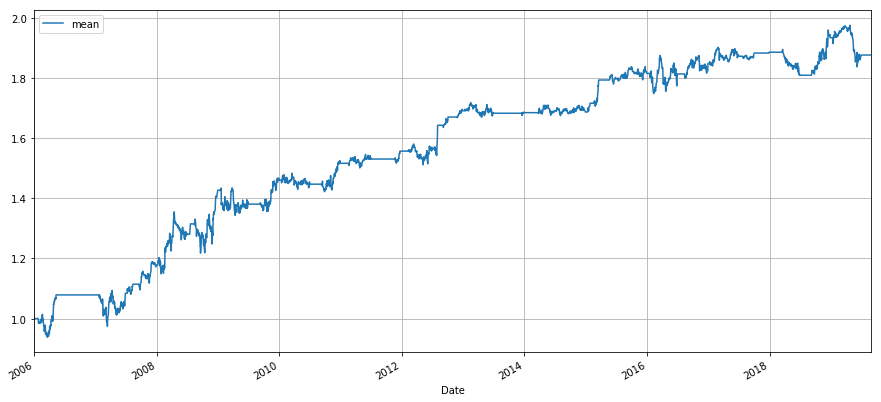

In [22]:
total_ret.plot(figsize=(15,7),grid=True)

In [23]:
perf = total_ret.calc_stats() 
perf.display()

Stat                 mean
-------------------  ----------
Start                2006-01-02
End                  2019-08-30
Risk-free rate       0.00%

Total Return         87.57%
Daily Sharpe         0.64
Daily Sortino        1.03
CAGR                 4.71%
Max Drawdown         -10.12%
Calmar Ratio         0.47

MTD                  0.00%
3m                   0.85%
6m                   -3.83%
YTD                  -2.98%
1Y                   3.71%
3Y (ann.)            0.88%
5Y (ann.)            2.10%
10Y (ann.)           3.12%
Since Incep. (ann.)  4.71%

Daily Sharpe         0.64
Daily Sortino        1.03
Daily Mean (ann.)    4.90%
Daily Vol (ann.)     7.67%
Daily Skew           0.22
Daily Kurt           10.10
Best Day             4.23%
Worst Day            -3.74%

Monthly Sharpe       0.73
Monthly Sortino      1.78
Monthly Mean (ann.)  4.98%
Monthly Vol (ann.)   6.84%
Monthly Skew         1.66
Monthly Kurt         6.27
Best Month           10.32%
Worst Month          -4.46%

Yearly Shar

In [14]:
tickers = pd.read_excel('C:/Users/jango/Documents/BFH/BTHE/Sectors.xlsx', sheet_name=None)

hc_tickers = tickers['Health Care'].Ticker.tolist()
cg_tickers = tickers['Consumer Goods'].Ticker.tolist()
fin_tickers = tickers['Financials'].Ticker.tolist()
test_tick = ['BARN', 'FORN', 'LISN', 'METN']

In [15]:
index = pd.read_csv('C:/Users/jango/code/research_env/BTHE/data/ALLN.csv')
df = pd.DataFrame(index['Adj Close']).set_index(index.Date)

In [16]:
for ticker in test_tick:
    datapath = ('C:/Users/jango/code/research_env/BTHE/data/'+ticker+'.csv')
    temp = pd.read_csv(datapath, index_col='Date', parse_dates=True)
    df[ticker] = temp['Adj Close']
    
df = df.drop(columns=['Adj Close'])
df.index = pd.to_datetime(df.index)
df_norm = (df - df.mean()) / (df.max() - df.min())
df_ind = (1 + df.pct_change()).cumprod()

In [17]:
df.head()

,BARN,FORN,LISN,METN
Date,,,,
2005-01-03,253.766815,212.862183,14097.915039,785.406067
2005-01-04,260.915222,216.254395,13889.367188,797.679871
2005-01-05,262.702332,224.734985,13764.236328,805.040833
2005-01-06,263.595825,223.038849,13680.816406,807.497192
2005-01-07,263.149139,223.674911,13518.149414,807.497192


In [18]:
pairs = create_pairs(test_tick)

In [19]:
ssd = find_ssd(df_ind['2017-01':'2018-01'], pairs)
for n in ssd:
    if ssd[n] > 0.0:
        print(n, ssd[n])

BARN,FORN 530.3080668018837
BARN,LISN 471.1464518966032
BARN,METN 596.0661671178337
FORN,LISN 1275.1818250500085
FORN,METN 1249.9817990361616
LISN,METN 36.73015290211239


In [13]:
find_tradeble_pairs(ssd)[0][0]

'LISN'

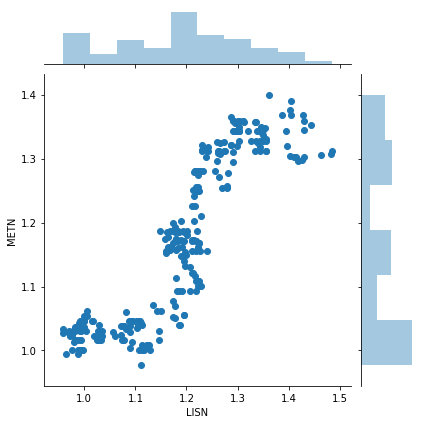

In [14]:
sns.jointplot(x="LISN", y="METN", data=df_ind['2005-01':'2006-01'])

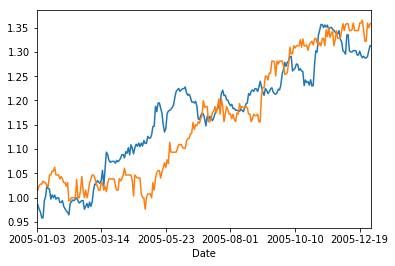

In [159]:
df_ind['LISN']['2005-01':'2006-01'].plot()
df_ind['METN']['2005-01':'2006-01'].plot()

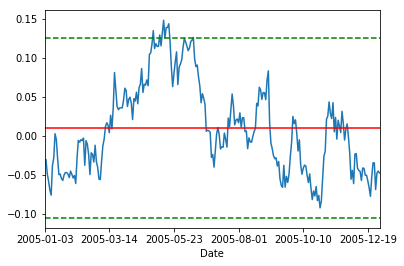

In [181]:
spread = df_ind['LISN']['2005-01':'2006-01'] - df_ind['METN']['2005-01':'2006-01']
mean = np.mean(spread)
stdev = np.std(spread)
upper = mean+2*stdev
lower = mean-2*stdev
spread.plot()
plt.axhline(mean, color='r', linestyle='-')
plt.axhline(upper, color='g', linestyle='--')
plt.axhline(lower, color='g', linestyle='--')

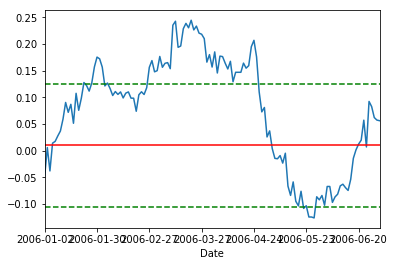

In [180]:
first_period = (1 + df['2006-01':'2006-07'].pct_change()).cumprod()
first_period_spread = df_ind['LISN']['2006-01':'2006-07'] - df_ind['METN']['2006-01':'2006-07']

first_period_spread.plot()

plt.axhline(mean, color='r', linestyle='-')
plt.axhline(mean+2*stdev, color='g', linestyle='--')
plt.axhline(mean-2*stdev, color='g', linestyle='--')

In [187]:
bt_df = pd.DataFrame()

In [193]:
bt_df['LISN'] = df['LISN']['2006-01':'2006-07']
bt_df['METN'] = df['METN']['2006-01':'2006-07']

bt_df['shortsignal'] = np.where(first_period_spread > upper, 1, 0)
bt_df['longsignal'] = np.where(first_period_spread < lower, 1, 0)
bt_df['closelong'] = np.where(first_period_spread > mean, 1, 0)
bt_df['closeshort'] = np.where(first_period_spread < mean, 1, 0)

In [391]:
backtest = bt(bt_df, 'LISN', 'METN')

going short: X 20104.806641 Y 1019.801025
closing short: X 22167.787109 Y 1232.105103
going long: X 19530.580078 Y 1173.200195
closing long: X 20876.787109 Y 1153.565186
2 trades were made


In [392]:
ret = pd.DataFrame(backtest.cum_returns)
ret.index = pd.to_datetime(ret.index)

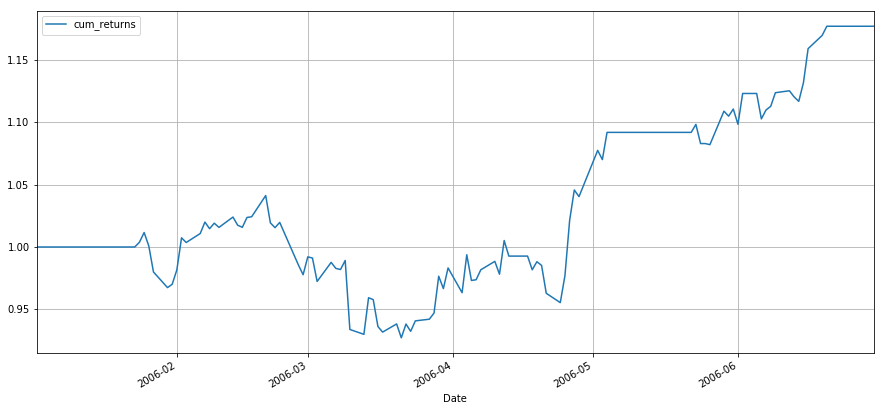

In [393]:
ret.iloc[0] = 1
ret.plot(figsize=(15,7),grid=True)

In [228]:
perf = ret.calc_stats() 
perf.display()

Stat                 cum_returns
-------------------  -------------
Start                2006-01-02
End                  2006-06-30
Risk-free rate       0.00%

Total Return         17.69%
Daily Sharpe         1.63
Daily Sortino        2.83
CAGR                 39.41%
Max Drawdown         -10.95%
Calmar Ratio         3.60

MTD                  5.97%
3m                   21.74%
6m                   -
YTD                  17.69%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  39.41%

Daily Sharpe         1.63
Daily Sortino        2.83
Daily Mean (ann.)    34.26%
Daily Vol (ann.)     20.98%
Daily Skew           0.01
Daily Kurt           3.28
Best Day             4.52%
Worst Day            -5.59%

Monthly Sharpe       4.53
Monthly Sortino      inf
Monthly Mean (ann.)  47.70%
Monthly Vol (ann.)   10.52%
Monthly Skew         -0.55
Monthly Kurt         -3.21
Best Month           6.75%
Worst Month          0.55%

Yearly Sharpe    

C:\Users\jango\Anaconda3\envs\research\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


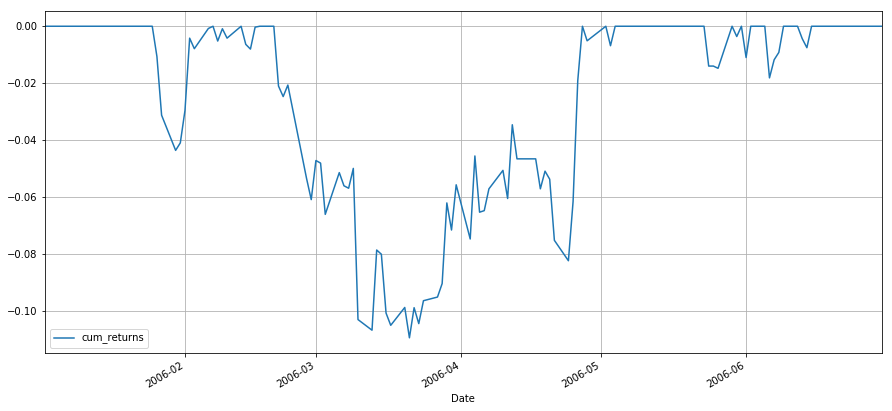

In [229]:
ffn.to_drawdown_series(ret).plot(figsize=(15,7),grid=True) 

In [324]:
start = pd.Timestamp('2005-01')

In [325]:
start + pd.DateOffset(month=6)

Timestamp('2005-06-01 00:00:00')

In [249]:
current_month = df.index[0]

for index, row in df['2015':'2017'].iterrows():
    if index < current_month and current_month.isoweekday() in range(1, 6):
        pass
    else:
        current_month = (index + pd.offsets.MonthEnd() - pd.DateOffset(1))
        if current_month.isoweekday() in range(6, 7):
            current_month = (current_month - pd.DateOffset(1))

    if index == current_month:
        print(current_month)

2015-01-30 00:00:00
2015-02-27 00:00:00
2015-03-30 00:00:00
2015-04-29 00:00:00
2015-05-29 00:00:00
2015-06-29 00:00:00
2015-07-30 00:00:00
2015-09-29 00:00:00
2015-10-30 00:00:00
2015-12-30 00:00:00
2016-01-29 00:00:00
2016-03-30 00:00:00
2016-04-29 00:00:00
2016-05-30 00:00:00
2016-06-29 00:00:00
2016-07-29 00:00:00
2016-08-30 00:00:00
2016-09-29 00:00:00
2016-11-29 00:00:00
2016-12-30 00:00:00
2017-01-30 00:00:00
2017-02-27 00:00:00
2017-03-30 00:00:00
2017-04-28 00:00:00
2017-05-30 00:00:00
2017-06-29 00:00:00
2017-08-30 00:00:00
2017-09-29 00:00:00
2017-10-30 00:00:00
2017-11-29 00:00:00
2017-12-29 00:00:00
